In [2]:
import pandas as pd
import json
import numpy as np
import geopy.distance
import geojson
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
from catboost import CatBoostRegressor
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Data Preparation

## Load data

In [3]:
apartments_train = pd.read_csv('data/apartments_train.csv')
buildings_train = pd.read_csv('data/buildings_train.csv')
apartments_test = pd.read_csv('data/apartments_test.csv')
buildings_test = pd.read_csv('data/buildings_test.csv')

train = pd.merge(
    apartments_train, 
    buildings_train.set_index('id'), 
    how='left', 
    left_on='building_id', 
    right_index=True
)
test = pd.merge(
    apartments_test, 
    buildings_test.set_index('id'), 
    how='left', 
    left_on='building_id', 
    right_index=True
)

## Replace missing coordinates and districts

**EDA insight:** TODO

In [4]:
ind = test[test["longitude"].isna()].index
test.at[ind, "latitude"] = 55.56776345324702
test.at[ind, "longitude"] = 37.48171529826662

**EDA insight:** TODO

In [5]:
ind = train[train.district.isna()].index
train.at[ind, "district"] = 12
ind = test[test.district.isna()].index
test.at[ind, "district"] = 12

## Fixing incorrect coordinates in testset

**EDA insight:** TODO

In [6]:
apartment_coordinates = {
    2511: [55.5438629741104, 37.48233890768276],
    2529: [55.66866253043727, 37.217152651528785],
    4719: [55.63132797843279, 37.426744466015705],
    5090: [55.54390546580924, 37.48229599441532],
    6959: [55.54390546580924, 37.48229599441532],
    8596: [55.54390546580924, 37.48229599441532],
    9547: [55.63399775464791, 37.41982879208156]
}
for k, v in apartment_coordinates.items():
    test.at[k, "latitude"] = v[0]
    test.at[k, "longitude"] = v[1]

# Exploratory Data Analysis

## Domain Knowledge

### Expensive districts
There are a range of districts within Moscow that are notorious for expensive apartments according to [Russia Beyond](https://www.rbth.com/travel/332318-expensive-rich-districts-moscow), including Khamovniki, Yakimanka, Arbat, Presnensky, Tverskoy, Meschansky, and Zamoskvorechye. Based on this information,
we created a set of features (is_in_khamovniki, is_in_yakimanka, etc.) using the polygon coordinates for each district obtained from open street map.

In [7]:
def wealthy_districts_features(data):
    with open("data/geojson/khamovniki_polygon_data.geojson") as f:
        gj_khamovniki = geojson.load(f)
    with open("data/geojson/yakimanka_polygon_data.geojson") as f:
        gj_yakimanka = geojson.load(f)
    with open("data/geojson/arbat_polygon_data.geojson") as f:
        gj_arbat = geojson.load(f)
    with open("data/geojson/presnensky_polygon_data.geojson") as f:
        gj_presnensky = geojson.load(f)
    with open("data/geojson/Tverskoy_polygon_data.geojson") as f:
        gj_tverskoy = geojson.load(f)
    khamovniki_polygon = Polygon(gj_khamovniki["geometries"][0]["coordinates"][0][0])
    yakimanka_polygon = Polygon(gj_yakimanka["geometries"][0]["coordinates"][0][0])
    arbat_polygon = Polygon(gj_arbat["geometries"][0]["coordinates"][0][0])
    presnensky_polygon = Polygon(gj_presnensky["geometries"][0]["coordinates"][0][0])
    tverskoy_polygon = Polygon(gj_tverskoy["geometries"][0]["coordinates"][0][0])
    for ind, row in data.iterrows():
        point = Point([row["longitude"], row["latitude"]])
        data.at[ind, "is_in_khamovniki"] = 1 if khamovniki_polygon.contains(point) else 0
        data.at[ind, "is_in_yakimanka"] = 1 if yakimanka_polygon.contains(point) else 0
        data.at[ind, "is_in_arbat"] = 1 if arbat_polygon.contains(point) else 0
        data.at[ind, "is_in_presnensky"] = 1 if presnensky_polygon.contains(point) else 0
        data.at[ind, "is_in_tverskoy"] = 1 if tverskoy_polygon.contains(point) else 0

### Metro stations
Moscow has a sophisticated metro network comprising 15 lines. Using a public list on [Wikipedia](https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations) comprising all stations and transitions, we constructed a wide range of features, including the distance to the nearest station, the number of lines that can be reached from that station, and whether or not a specific metro line is accessible.

In [8]:
def distance_to_metro_feature(data, add_metro_lines=True):
    d = data.copy()

    metro_data = pd.read_csv("data/moscow_metro_data.csv", delimiter=";")

    # drop duplicates
    ind = metro_data[metro_data["English transcription"].duplicated()].index
    metro_data = metro_data.drop(ind)
    metro_data = metro_data.reset_index()
    metro_lines = ["metro_line_{}".format(i) for i in range(1, 16)]

    nbrs = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(metro_data[["latitude", "longitude"]])
    distances, indices = nbrs.kneighbors(d[["latitude", "longitude"]])
    d["metro_index"] = indices

    for ind, row in d.iterrows():
        metro_coordinate = metro_data.loc[[row.metro_index]][["latitude", "longitude"]].to_numpy()
        distance = geopy.distance.distance([[row["latitude"], row["longitude"]]], metro_coordinate).km
        data.at[ind, "distance_to_metro"] = distance

        if add_metro_lines:
            number_of_metro_lines = 0
            metro_lines_data = metro_data.loc[[row.metro_index]][metro_lines]
            for metro_line in metro_lines:
                access_to_line = metro_lines_data[metro_line].values[0]
                data.at[ind, metro_line] = access_to_line
                if access_to_line == 1:
                    number_of_metro_lines += 1
            data.at[ind, "number_of_metro_lines"] = number_of_metro_lines

### Hospitals
Using data from open street map, we computed the distance to the nearest hospital, which had a positive effect on our model.

In [9]:
def distance_to_hospital_feature(data):
    d = data.copy()
    hospital_data = pd.read_csv("data/hospitals.csv")
    hospital_data = hospital_data[["latitude", "longitude"]]
    nbrs = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(hospital_data)
    distances, indices = nbrs.kneighbors(data[["latitude", "longitude"]])
    d["hospital_index"] = indices
    distances = []
    for ind, row in d.iterrows():
        apartment_coordinates = [[row["latitude"], row["longitude"]]]
        hospital_coordinate = hospital_data.loc[[row.hospital_index]].to_numpy()
        distance = geopy.distance.distance(apartment_coordinates, hospital_coordinate).km
        distances.append(distance)
    data["distance_to_hospital"] = distances

### Universities
Moscow has a great number of universities. However, two of the most important universities are the Moscow State University and the Technical University of Moscow. Apartments close to the universities have a tendency to increase in price. Hence, we added a feature measuring the distance to both universities.

In [10]:
def distance_to_universities_feature(data):
    state_uni_coordinates = [55.70444300116007, 37.528611852796914]
    tech_uni_coordinates = [55.76666597872545, 37.68511242319504]
    distances_to_state_uni = []
    distances_to_tech_uni = []
    for ind, row in data.iterrows():
        distances_to_state_uni.append(geopy.distance.distance([row["latitude"], row["longitude"]], state_uni_coordinates).km)
        distances_to_tech_uni.append(geopy.distance.distance([row["latitude"], row["longitude"]], tech_uni_coordinates).km)
    data["distance_to_state_uni"] = distances_to_state_uni
    data["distance_to_tech_uni"] = distances_to_tech_uni

### Distance to city center
Apartments closer to the city center often have a higher price than those further away. Hence, we created a distance_to_center feature based on latitude and longitude giving the distance to the center of moscow in kilometers.

In [11]:
def distance_to_center_feature(data):
    moscow_center = [55.751244, 37.618423]
    coordinates = data[['latitude', 'longitude']].to_numpy()
    dist = [geopy.distance.distance(moscow_center, coordinate).km for coordinate in coordinates]
    data['distance_to_center'] = dist

### Bearing
We noticed that apartments in the center and western part of moscow tend to have higher prices than others. Thus, we calculated the bearing from the city center based on the latitude and longitude coordinates.

In [12]:
def bearing_feature(data):
    for ind, row in data.iterrows():
        moscow_center = [55.751244, 37.618423]
        c1 = moscow_center
        c2 = [row["latitude"], row["longitude"]]
        y = np.sin(c2[1] - c1[1]) * np.cos(c2[0])
        x = np.cos(c1[0]) * np.sin(c2[0]) - np.sin(c1[0]) * np.cos(c2[0]) * np.cos(c2[1] - c1[1])
        rad = np.arctan2(y, x)
        bearing = ((rad * 180 / np.pi) + 360) % 360
        data.at[ind, "bearing"] = bearing

### Box areas
We further split the map into different coordinate tiles to better capture the more expensive apartments. 

In [13]:
def add_box_areas_more_boxes(data):
    """only add values in list to prevent unnecessary slowdown"""
    locs_with_high_corr = [
            'loc_37.575_55.75', 'loc_37.6_55.725', 'loc_37.525_55.75',
           'loc_37.55_55.775', 'loc_37.525_55.725', 'loc_37.575_55.725',
           'loc_37.525_55.7', 'loc_37.5_55.7', 'loc_37.55_55.725',
           'loc_37.475_55.7', 'loc_37.625_55.725', 'loc_37.5_55.75',
           'loc_37.525_55.775', 'loc_37.525_55.675', 'loc_37.55_55.675',
           'loc_37.55_55.75', 'loc_37.4_55.6', 'loc_37.725_55.575',
           'loc_37.925_55.675', 'loc_37.475_55.55', 'loc_37.65_55.575',
           'loc_37.525_55.875', 'loc_37.5_55.55', 'loc_37.475_55.525',
           'loc_37.925_55.7'
    ]
    for lon in np.arange(37.4, 37.95, 0.025):
        for lat in np.arange(55.525, 55.9, 0.025):
            column_name = "loc_" + str(round(lon, 3)) + "_" + str(round(lat, 3))
            if column_name in locs_with_high_corr: #column_name in locs_with_high_corr:
                data[column_name] = 0
                indexes = data[
                    (lon < data['longitude']) & (data['longitude'] < lon + 0.025) & (lat < data['latitude']) & (
                                data['latitude'] < lat + 0.025)
                    ].index

                data.loc[indexes, column_name] = 1

In [83]:
def construct_features(data):
    distance_to_center_feature(data)
    distance_to_metro_feature(data)
    bearing_feature(data)
    distance_to_hospital_feature(data)
    distance_to_universities_feature(data)
    wealthy_districts_features(data)
    add_box_areas_more_boxes(data)

train_with_feats = train.copy()
test_with_feats = test.copy()
construct_features(train_with_feats)
construct_features(test_with_feats)

## Understand how the data was generated

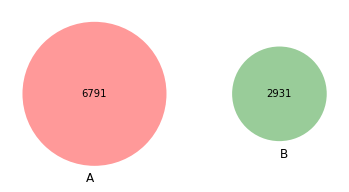

In [14]:
from matplotlib_venn import venn2, venn2_circles
import matplotlib.pyplot as plt

train_buildings = set(train.building_id.values)
test_buildings = set(test.building_id.values)
venn2([train_buildings, test_buildings])
plt.show()

As we can see from the venn diagram above, there is no overlap between the building_ids in the training and test data, showing that the buildings in the test data are completely different from those in the training data. Hence, in order to obtain accurate results during model validation, the training set should be split in a validation and training set based on the same assumptions.

## Explore individual features

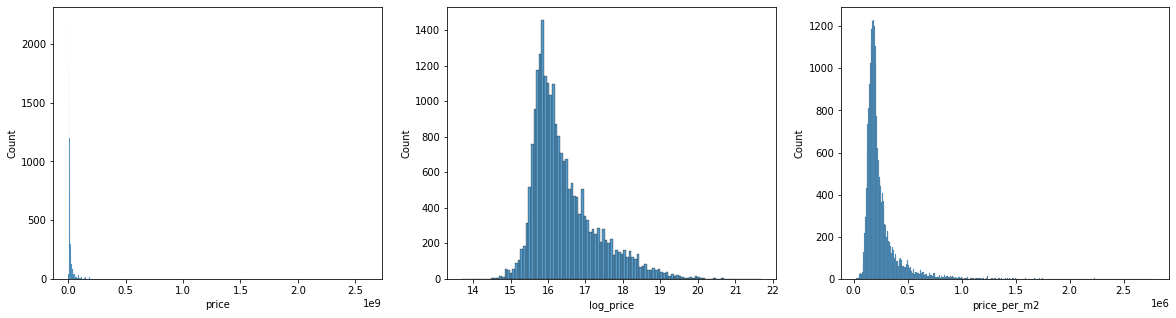

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.histplot(data=train["price"], ax=ax[0])
train["log_price"] = np.log1p(train["price"])
sns.histplot(data=train["log_price"], ax=ax[1])
train["price_per_m2"] = train["price"] / train["area_total"]
sns.histplot(data=train["price_per_m2"], ax=ax[2])
plt.show()

**EDA insight:** As we can see, the unadjusted price is significantly right skewed. While computing the price per square meter looks a bit better, a log transformation of the price is even better.

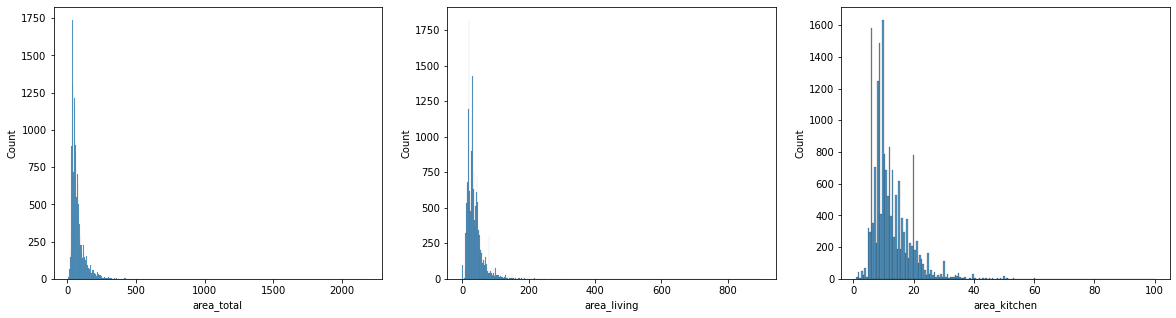

Skewness in training data:


,area_total,area_living,area_kitchen
Skew,8.610355,5.319536,2.207571


In [70]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.histplot(data=train["area_total"], ax=ax[0])
sns.histplot(data=train["area_living"], ax=ax[1])
sns.histplot(data=train["area_kitchen"], ax=ax[2])
plt.show()

print("Skewness in training data:")
skew_feats = train[['area_total', 'area_kitchen','area_living']].skew().sort_values(ascending=False)
pd.DataFrame({'Skew': skew_feats}).T

Eda insight: Area total and area_living are a bit skewed, but a log transformation did not seem to help

## Explore pairs and groups of features

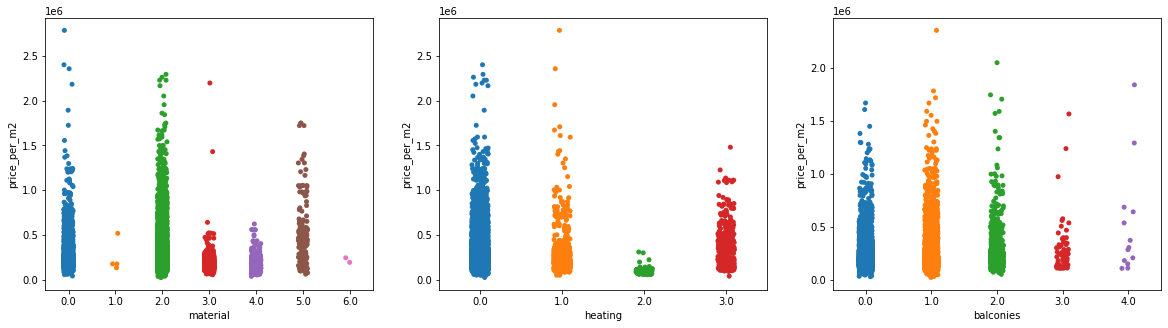

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.stripplot(x="material", y="price_per_m2",  data=train, ax=ax[0])
sns.stripplot(x="heating", y="price_per_m2",  data=train, ax=ax[1])
sns.stripplot(x="balconies", y="price_per_m2",  data=train,  ax=ax[2])
plt.show()

<AxesSubplot:xlabel='distance_to_center', ylabel='area_total'>

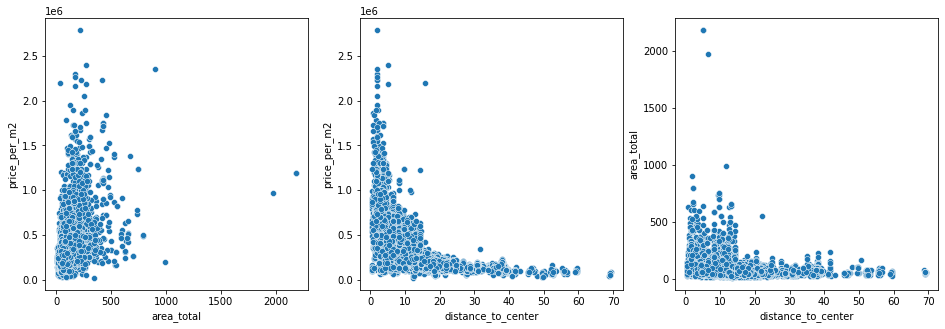

In [86]:
fig, ax =plt.subplots(1,3, figsize=(16,5))
sns.scatterplot(x="area_total", y="price_per_m2", data=train_with_feats, ax=ax[0])
sns.scatterplot(x="distance_to_center", y="price_per_m2", data=train_with_feats, ax=ax[1])
sns.scatterplot(x="distance_to_center", y="area_total", data=train_with_feats, ax=ax[2])



**EDA insight:** The m2 price increases significantly with a shorter distance and indicates a clearer relationship than the price alone. However, there is still a strong variability which needs to be further investigated. What distinguishes cheap houses that are close to the center from expensive ones? Age? Number of stories? The street they are placed in? The price of other houses in the vicinity?

Correlation area_living: 0.7496293729728276 | Correlation log_area_living: 0.7091494404484565


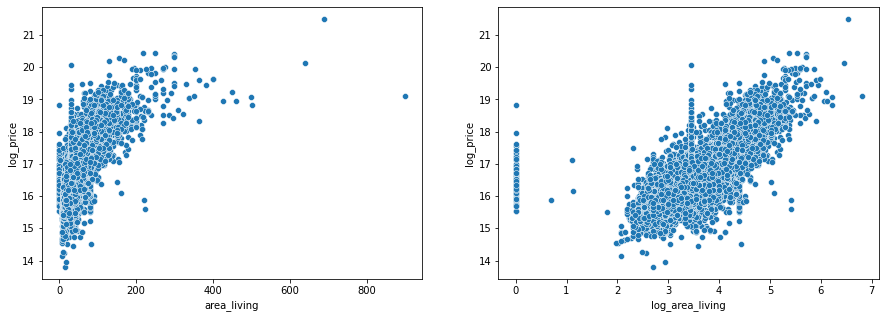

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x="area_living", y="log_price", data=d, ax=ax[0])
d["log_area_living"] = np.log1p(d["area_living"])
sns.scatterplot(x="log_area_living", y="log_price", data=d, ax=ax[1])
print("Correlation area_living: {} | Correlation log_area_living: {}".format(d["area_living"].corr(d["log_price"]), d["log_area_living"].corr(d["log_price"])))

**EDA insight:** Area living seems to have some values set to zero, which have quite high price. This seems like a mistake, and was corrected:

In [88]:
train_data.loc[train_data.area_living==0, 'area_living'] = train_data[train_data.area_living==0].area_total * 0.56

## Clean up features - Data imputation
We imputed all features in the data provided using different approaches for boolean, categorical, and numerical features. 

### Categorical features
In case of categorical features, we simply added a new category for all rows with nans. For instance, in the catgory 'seller', nan values were replaced with category 4 denoting 'other_seller'.

We made an exception for 'windows_street' and 'windows_court' since we cannot assume that all the other buildings don't have any windows to the street or court if this feature contains nans. Hence, we used the bins approach as explained below.

In [23]:
def impute_categorical_features(data):
    data.loc[:, "seller"] = data.loc[:, "seller"].fillna(4)
    data.loc[:, "layout"] = data.loc[:, "layout"].fillna(3)
    data.loc[:, "condition"] = data.loc[:, "condition"].fillna(4)
    data.loc[:, "material"] = data.loc[:, "material"].fillna(7)
    data.loc[:, "parking"] = data.loc[:, "parking"].fillna(3)
    data.loc[:, "heating"] = data.loc[:, "heating"].fillna(4)

### Boolean features
If a boolean feature contained a nan, we generally interpreted it as 'not present', i.e., we set it to 0. 

In [24]:
def impute_boolean_features(data):
    data.loc[:, "elevator_without"] = data.loc[:, "elevator_without"].fillna(0)
    data.loc[:, "elevator_service"] = data.loc[:, "elevator_service"].fillna(0)
    data.loc[:, "elevator_passenger"] = data.loc[:, "elevator_passenger"].fillna(0)
    data.loc[:, "garbage_chute"] = data.loc[:, "garbage_chute"].fillna(0)
    data.loc[:, "balconies"] = data.loc[:, "balconies"].fillna(0)
    data.loc[:, "loggias"] = data.loc[:, "loggias"].fillna(0)

### Numerical features
In case of numerical features, we tried to avoid to simply set it to the mean value as this would probably lead to a distortion of the real data. Instead, we imputed it using bins based on area_total. We computed k bins based on area_total, calculated the mean for a given feature in the corresponding bin, and replaced nans in this range with the computed value.

An exception is constructed. Before imputing it based on bins, we set constructed to 2021 if new was True.

In [25]:
def impute_with_bin_mean(data, train_data, test_data, feature, bin_feature, bins=40, decimals=0, verbose=False):
    tr = train_data.copy()
    te = test_data.copy()
    database = pd.concat([tr, te])
    database["bin"], bins = pd.cut(database[bin_feature], bins=40, retbins=True)
    pb = 0
    for b in bins:
        bin_data = database[(database[bin_feature] >= pb) & (database[bin_feature] <= b)]
        bin_mean = bin_data[feature].mean()
        percentage = (bin_mean / bin_data[bin_feature]).mean()
        d = data[(data[bin_feature] >= pb) & (data[bin_feature] <= b)]
        ind = d[d[feature].isna()].index
        if pd.notna(bin_mean) and len(ind) > 0:
            bin_mean = round(bin_mean, decimals)
            data.at[ind, feature] = bin_mean
            if verbose:
                print(
                    "Set {} for {} rows with {} <= {} <= {} to {}".format(feature, len(ind), pb, bin_feature, b, bin_mean))
        pb = b

In [26]:
def impute_numerical_features(data):
    data.loc[data.new == 1, "constructed"] = data.loc[data.new == 1, "constructed"].fillna(2021)
    impute_with_bin_mean(data=data, train_data=train, test_data=test, feature="constructed", bins=12, bin_feature="district")
    data.loc[data.constructed >= 2021, "new"] = data.loc[data.constructed >= 2021, "new"].fillna(1)
    data.loc[data.constructed < 2021, "new"] = data.loc[data.constructed < 2021, "new"].fillna(0)
    
    numerical_features = ["phones", "ceiling", "bathrooms_shared", "bathrooms_private", "windows_street", "windows_court", "area_kitchen", "area_living"]
    for num_feat in numerical_features:
        impute_with_bin_mean(data=data, train_data=train, test_data=test, feature=num_feat, bin_feature="area_total", bins=20)
        fill_value = data[data[num_feat].notna()][num_feat].mean(axis=0).round()
        data.loc[:, num_feat] = data.loc[:, num_feat].fillna(fill_value)
    

domain knowledge: 
- there are some notorious expensive areas in moscow (refer to news article)
- metro stations could play an important role and the lines that are accessible
- hospitals may also be important

understand how the data was generated:
- show that the train and test was split based on building id

explore individual features:
- add plots from previous notebooks

clean up features:
- refer to data imputation methods

explore pairs and groups:
- analyse area_total with respect to area_kitchen, area_living, and rooms to show that they have a high correlation

# Feature Engineering
The new features that we added were explained extensively above in the section 'domain knowledge'. In addition to that, we also performed a log transformation of the price and computed the price per square meter as this improved model performance significantly.

## Target features in training set

In [6]:
train["log_price"] = np.log1p(train.price)
train["price_per_m2"] = train.price / train.area_total

In [30]:

def impute_nans(data):
    impute_categorical_features(data)
    impute_boolean_features(data)
    impute_numerical_features(data)

train_data = train_with_feats.copy()
test_data = test_with_feats.copy()
impute_nans(train_data)
impute_nans(test_data)

# One-hot encoding categorical features
We one-hot encoded all categorical features and dropped the original feature.

In [31]:
district_categories = {
    3: "East",
    6: "South-West",
    5: "South",
    4: "South-East",
    0: "Central",
    2: "North-East",
    1: "North",
    8: "North-West",
    7: "West",
    11: "Novomoskovsk",
    10: "Troitsk",
    9: "Zelenograd",
    12: "Other_district"
}
material_categories = {
    0: "Bricks",
    1: "Wood",
    2: "Monolith",
    3: "Panel",
    4: "Block",
    5: "Monolithic_brick",
    6: "Stalin_project",
    7: "Other_material"
}
heating_categories = {
    0: "Central",
    1: "Individual",
    2: "Boiler",
    3: "Autonomous_boiler",
    4: "Other_heating"
}
parking_categories = {
    0: "Ground",
    1: "Underground",
    2: "Multilevel",
    3: "No_parking"
}
seller_categories = {
    0: "Owner",
    1: "Company",
    2: "Agents",
    3: "Developer",
    4: "Other_seller"
}
layout_categoires = {
    0: "Adjacent",
    1: "Isolated",
    2: "Adjacent_isolated",
    3: "Other_layout"
}
condition_categories = {
    0: "Undecorated",
    1: "Decorated",
    2: "Euro_repair",
    3: "Special_design",
    4: "Other_condition"
}
categorical_features = {
    "parking": parking_categories,
    "heating": heating_categories,
    "material": material_categories,
    "district": district_categories,
    "seller": seller_categories,
    "layout": layout_categoires,
    "condition": condition_categories
}

In [32]:
def one_hot_encode_categorical_features(data, remove_org=True):
    for orig_feat, categories in categorical_features.items():
        for k, category in categories.items():
            data[category] = (data[orig_feat] == k).astype(int)
        if remove_org:
            data.drop(orig_feat, axis=1, inplace=True)
one_hot_encode_categorical_features(train_data)
one_hot_encode_categorical_features(test_data)

# Outliers

## Min-Max Outliers
We analysed the test data with respect to the min and max values of each feature. If a row in the train data contains a value in one of the features that is greater than the min or max value, we removed the row from the training data.

In [35]:
def remove_min_max_outliers(train_data, test_data, features):
    t = train_data.copy()
    test_feat_min_max = pd.DataFrame({"max": test_data.describe().loc["max"], "min": test_data.describe().loc["min"]}).T
    for feature in features:
        max_val = test_feat_min_max[feature]["max"]
        min_val = test_feat_min_max[feature]["min"]
        max_ind = t[t[feature] > max_val].index
        min_ind = t[t[feature] < min_val].index
        t.drop(max_ind, inplace=True)
        t.drop(min_ind, inplace=True)

    print("Samples before: {} | Samples after: {}".format(len(train_data), len(t)))
    return t
relevant_outlier_columns = test_data.columns.drop(["id", "building_id", "street", "address", "price", "log_price", "price_per_m2", "street", "address"], errors="ignore")
train_data = remove_min_max_outliers(train_data, test_data, relevant_outlier_columns)

Samples before: 23285 | Samples after: 23063


In [24]:
train_data = train_data.reset_index()

# Training and Prediction

## Feature selection
Selecting the features that should be part of the training set.

In [46]:
features = train_data.columns
features = features.drop(["id", "building_id", "street", "address", "price", "log_price", "price_per_m2", "street", "address", 'bin'], errors="ignore")

In [40]:
def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

## Model 1: Stacking using averaging
Our first model comprises LGBMRegressor, CatBoostRegressor, and a BaggingRegressor. We initially optimised the models using cross-validation to find the best hyperparameters. We saved the obtained scores of each model as this is required for the prediction to work. Thereafter, we trained the base models on the entire training set, predicted the prices of the test set with each model, and computed the weighted average with the weights based on the scores obtained in cross-validation.

### Training

In [41]:
SEED = 42
model2 = lgbm.LGBMRegressor(
    random_state=SEED,
    learning_rate=0.1,
    n_estimators=2000,
    boosting_type='gbdt',
    n_jobs=2,
    num_leaves=20,
    min_data_in_leaf=12,
    max_depth=20,
    max_bin=160,
)

model3 = CatBoostRegressor(
    n_estimators=1000,
    learning_rate=0.2,
    thread_count=2,
    depth=7,    
    min_data_in_leaf=10,
    silent=True,
    random_seed=SEED,
)

model5 = BaggingRegressor(
    n_estimators=200,
    n_jobs=2,
    random_state=SEED,
    max_features=0.7,
    max_samples=0.8,
)

In [42]:
def cross_validation(model, k, data, features, target_feature):
    """Splits based on building id"""
    kf = KFold(
        n_splits=k,
        shuffle=True,
        random_state=SEED
    )
    train_scores = []
    val_scores = []
    
    for i, (train_index, test_index) in tqdm(enumerate(kf.split(buildings_train)), total=k):
        building_val_ids = buildings_train.id.values[test_index]
        train = data[~data.building_id.isin(building_val_ids)]
        val = data[data.building_id.isin(building_val_ids)]
        X_train = train[features].values
        X_val = val[features].values
        y_train = train[[target_feature]].values.ravel()
        y_val = val[[target_feature]].values.ravel()
        y_train_true = train[["price"]].values.ravel()
        y_val_true = val[["price"]].values.ravel()

        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)
        
        if target_feature == "log_price":
            train_pred = (np.e ** train_pred) - 1
            val_pred = (np.e ** val_pred) - 1
        elif target_feature == "price_per_m2":
            train_pred = train_pred * train.area_total
            val_pred = val_pred * val.area_total
        else:
            raise Exception("Unknown target feature")
            
        train_rsmle = root_mean_squared_log_error(y_true=y_train_true, y_pred=train_pred)
        val_rsmle = root_mean_squared_log_error(y_true=y_val_true, y_pred=val_pred)
        train_scores.append(train_rsmle)
        val_scores.append(val_rsmle)
    train_scores = np.array(train_scores)
    val_scores = np.array(val_scores)
    print("Train rsmle: {} | Std: {}".format(train_scores.mean(), train_scores.std()))
    print("Val rsmle: {} | Std: {}".format(val_scores.mean(), val_scores.std()))
    return val_scores.mean()

In [47]:
f = features.copy()
f = f.drop(["area_living", "area_kitchen", "rooms"])

model2_scores = cross_validation(model2, 5, train_data, f, "log_price")
model3_scores = cross_validation(model3, 5, train_data, f, "log_price")
model5_scores = cross_validation(model5, 5, train_data, f, "price_per_m2")
scores = {
    "lgbm": model2_scores,
    "cb": model3_scores,
    "bagging": model5_scores,
}

  0%|                                                                                                                                                                                                             | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 20%|███████████████████████████████████████▍                                                                                                                                                             | 1/5 [00:03<00:15,  3.76s/it]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 40%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 2/5 [00:07<00:11,  3.73s/it]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 3/5 [00:11<00:07,  3.65s/it]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 4/5 [00:15<00:03,  3.99s/it]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.83s/it]


Train rsmle: 0.04353914529733595 | Std: 0.0008279783609982375
Val rsmle: 0.19780486182129559 | Std: 0.020068732311686478


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.02s/it]


Train rsmle: 0.0532992151356473 | Std: 0.0007429125779809247
Val rsmle: 0.20431493790361754 | Std: 0.02537317884374216


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:32<00:00, 18.48s/it]

Train rsmle: 0.06218248470799872 | Std: 0.0011581391012851201
Val rsmle: 0.20663043852500165 | Std: 0.028480074941073293


In [48]:
model_scores = pd.DataFrame(scores, index=[0])
model_scores = model_scores.T
model_scores.columns = ["rsmle"]
model_scores

,rsmle
lgbm,0.197805
cb,0.204315
bagging,0.206630


### Model interpretation

### Prediction using model 1

In [49]:
model2.fit(train_data[features], train_data["log_price"])
model3.fit(train_data[features], train_data["log_price"])
model5.fit(train_data[features], train_data["price_per_m2"])

model2_pred = model2.predict(test_data[features])
model3_pred = model3.predict(test_data[features])
model5_pred = model5.predict(test_data[features])

model2_pred = (np.e ** model2_pred) - 1
model3_pred = (np.e ** model3_pred) - 1
model5_pred *= test_data.area_total

predictions = [model2_pred, model3_pred, model5_pred]
pred = np.average(predictions, 
    weights = 1 / model_scores['rsmle'] ** 4,
    axis=0
)
submission = pd.DataFrame()
submission['id'] = test_data.id
submission['price_prediction'] = pred
submission.to_csv('submission.csv', index=False)

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


## Model 2: Stacking with meta model
In our second model, we replaced the averaing step of model 1 with a meta model that tries to minimize the prediction errors of the base models.

### Training of the base models

In [50]:
def custom_cv(data, building_data, k):
    kf = KFold(
        n_splits=k,
        shuffle=True,
        random_state=SEED
    )
    inds = [ind for i, ind in enumerate(kf.split(building_data))]
    i = 0
    while i < len(inds):
        building_val_ids = building_data.id.values[inds[i][1]]
        train_ids = data[~data.building_id.isin(building_val_ids)].index.values
        val_ids = data[data.building_id.isin(building_val_ids)].index.values
        yield (train_ids, val_ids)
        i += 1

In [51]:
def train_val_split(data, buildings_data, features, target, ratio=0.2):
    sample_count = round(0.2 * buildings_data.shape[0])
    buildings_val = buildings_data.sample(sample_count)
    buildings_train_data = buildings_data[~buildings_data.id.isin(buildings_val.id)]
    X_train = data[~data.building_id.isin(buildings_val.id)]
    X_val = data[data.building_id.isin(buildings_val.id)]
    return X_train, X_val, buildings_train_data

In [52]:
X_train, X_val, buildings_train_data = train_val_split(train_data, buildings_train, f, "log_price")

In [53]:
def get_oof(clf, x_train, x_test, features, target, buildings_train_data):
    """
    Popular function on Kaggle.
    
    Trains a classifier on 4/5 of the training data and
    predicts the rest (1/5). This procedure is repeated for all 5 folds,
    thus we have predictions for all training set. This prediction is one
    column of meta-data, later on used as a feature column by a meta-algorithm.
    We predict the test part and average predictions across all 5 models.
    
    Keyword arguments:
    clf -- classifier
    x_train -- 4/5 of training data
    y_train -- corresponding labels
    x_test -- all test data
    
    """
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((5, ntest))
    x_train = x_train.reset_index()
    x_test = x_test.reset_index()

    
    for i, (train_index, test_index) in tqdm(enumerate(custom_cv(x_train, buildings_train_data, 5)), total=5):
        x_tr = x_train.loc[train_index, features]
        y_tr = x_train.loc[train_index, target]
        x_te = x_train.loc[test_index, features]

        clf.fit(x_tr, y_tr)
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test[features])

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [54]:
def ensemble_predict(models, meta_model, X):
    meta_prediction = np.zeros((X.shape[0], len(models)))
    for i, model in enumerate(models):
        meta_prediction[:, i] = model.predict(X)
    return meta_model.predict(meta_prediction)

In [55]:
from sklearn.ensemble import GradientBoostingRegressor

base_model1 = lgbm.LGBMRegressor(
    random_state=SEED,
    learning_rate=0.1,
    n_estimators=2000,
    boosting_type='gbdt',
    n_jobs=2,
    num_leaves=20,
    min_data_in_leaf=12,
    max_depth=20,
    max_bin=160,
)

base_model2 = CatBoostRegressor(
    n_estimators=1000,
    learning_rate=0.2,
    thread_count=2,
    depth=7,    
    min_data_in_leaf=10,
    silent=True,
    random_seed=SEED,
)

base_model3 = BaggingRegressor(
    n_estimators=200,
    n_jobs=2,
    random_state=SEED,
    max_features=0.7,
    max_samples=0.8,
)

base_model4 = RandomForestRegressor(
    n_estimators=200,
    criterion='mse',
    n_jobs=2,
    random_state=SEED,
    max_features='log2',
    bootstrap=False,
    max_depth=23,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=1.6746306849395426e-07
)

base_model5 = GradientBoostingRegressor(
    learning_rate=0.3830043942496965,
    n_estimators=100,
    criterion='friedman_mse',
    max_depth=10,
    subsample=0.9115382776453557,
    random_state=SEED
)

base_model6 = XGBRegressor(
    random_state=SEED
)

In [56]:
model1_oof_train, model1_oof_val = get_oof(base_model1, X_train, X_val, f, "log_price", buildings_train_data)
model2_oof_train, model2_oof_val = get_oof(base_model2, X_train, X_val, f, "log_price", buildings_train_data)
model3_oof_train, model3_oof_val = get_oof(base_model3, X_train, X_val, f, "log_price", buildings_train_data)
model4_oof_train, model4_oof_val = get_oof(base_model4, X_train, X_val, f, "log_price", buildings_train_data)
model5_oof_train, model5_oof_val = get_oof(base_model5, X_train, X_val, f, "log_price", buildings_train_data)
model6_oof_train, model6_oof_val = get_oof(base_model6, X_train, X_val, f, "log_price", buildings_train_data)

  0%|                                                                                                                                                                                                             | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 20%|███████████████████████████████████████▍                                                                                                                                                             | 1/5 [00:02<00:10,  2.56s/it]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 40%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 2/5 [00:05<00:07,  2.57s/it]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 3/5 [00:07<00:05,  2.57s/it]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 4/5 [00:10<00:02,  2.51s/it]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.50s/it]


In [57]:
x_train_m = np.concatenate((
    model1_oof_train,
    model2_oof_train,
    model3_oof_train,
    model4_oof_train,
    model5_oof_train,
    model6_oof_train,
), axis=1)

x_val_m = np.concatenate((
    model1_oof_val,
    model2_oof_val,
    model3_oof_val,
    model4_oof_val,
    model5_oof_val,
    model6_oof_val,
), axis=1)

### Training of the meta model

In [58]:
META_MODEL = lgbm.LGBMRegressor(
    random_state=SEED,
    learning_rate=0.07,
    n_estimators=100,
    boosting_type='gbdt',
    n_jobs=2,
    num_leaves=20,
    min_data_in_leaf=12,
    max_depth=15,
    max_bin=160,
)

META_MODEL.fit(x_train_m, X_train["log_price"])
train_pred = META_MODEL.predict(x_train_m)
pred = META_MODEL.predict(x_val_m)

train_rsmle = root_mean_squared_log_error(y_true=(np.e ** X_train["log_price"]) - 1, y_pred=(np.e ** train_pred) - 1)
rsmle = root_mean_squared_log_error(y_true=(np.e ** X_val["log_price"]) - 1, y_pred=(np.e ** pred) - 1)
print("Train rsmle: {} | Val rsmle: {}".format(train_rsmle, rsmle))

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
Train rsmle: 0.17720968656748903 | Val rsmle: 0.17808959986047526


### Prediction using model 2
The base models are retrained on the entire training set, while the meta model remains as it is.

In [59]:
base_model1.fit(train_data[f], train_data["log_price"])
base_model2.fit(train_data[f], train_data["log_price"])
base_model3.fit(train_data[f], train_data["log_price"])
base_model4.fit(train_data[f], train_data["log_price"])
base_model5.fit(train_data[f], train_data["log_price"])
base_model6.fit(train_data[f], train_data["log_price"])

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [60]:
model1_pred = base_model1.predict(test_data[f])
model2_pred = base_model2.predict(test_data[f])
model3_pred = base_model3.predict(test_data[f])
model4_pred = base_model4.predict(test_data[f])
model5_pred = base_model5.predict(test_data[f])
model6_pred = base_model6.predict(test_data[f])

meta_preds = np.array([model1_pred, model2_pred, model3_pred, model4_pred, model5_pred, model6_pred])
meta_preds = meta_preds.T

pred = META_MODEL.predict(meta_preds)
pred = (np.e ** pred) - 1

In [61]:
submission = pd.DataFrame()
submission['id'] = test_data.id
submission['price_prediction'] = pred
submission.to_csv('submission_meta.csv', index=False)